# CAPSTONE PROJECT: CAN THE COMPUTERS READ IT TOO?

# 1: DATA PREPARATION

## 1.1 Setting up the notebook

In [1]:
import io
import os
import glob
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

In [2]:
cache_dir = 'cache' # The folder we will use for storing data
data_dir = os.path.join(cache_dir, 'data')
model_dir = os.path.join(cache_dir, 'model')

import pickle

# DURING THE NOTEBOOK YOU WILL FIND VARIOUS NUMBER OF CELLS THAT CONSISTS ONLY TO CLEAN FILES IN ORDER TO HAVE AS MUCH SPACE POSSIBLE AND NOT HAVE PROBLEMS WITH IT.

# THE TRAIN DATA NEEDS TO BE TRANSFORMED AS WE DO, BUT THE TEST DATA DOESNT NEED TO AS THE PREDICT WILL CONVERT FROM THE STRING TO THE ADECUATED FORM FOR THE MODEL

## 1.2 Downloading the data

First we will download the data.

In [3]:
if 'blogger.zip' not in os.listdir('.'):
    !wget -O blogger.zip http://www.cs.biu.ac.il/~koppel/blogs/blogs.zip
else:
    print('zip already downloaded')
if 'blogs' not in os.listdir('.'):
    !unzip -Z1 blogs.zip | head -10 | sed 's| |\\ |g' | xargs unzip blogs.zip
else:
    print('zip already unziped')


zip already downloaded
zip already unziped


In [4]:
# print(len([name for name in os.listdir('blogs') if os.path.isfile(name)]))
print(len(os.listdir('blogs/')))

9


As it was pretty big with, maybe, too much files (considering that inside each blog normally there are more than one post) so only a subset of it was unzipped. The subset selected is on the head part of the command, in this case resulted in 9 blogs.

# DELETE ZIP FILE IF YOU ARE NOT USING ANYMORE TO CLEAR SOME SPACE

## 1.3 Preparing and Processing the data

### Preparation

In [5]:
path = os.path.join('blogs', '*.xml')
files = glob.glob(path)

with open(files[0]) as f:
    print(f.read())

<Blog>

<date>30,July,2004</date>
<post>

	 
       Planning the Marathon   I checked Active.com, and the registration for the 2005 Spirit of St. Louis Marathon doesn't open until 8am August 15.&nbsp; I'm planning to get online at 8:01am and signup.&nbsp;   I like doing triathlons andwill probably sign up for another one next year, but I think that I'm going to make running my primary focus for the next 6 months after the tri, starting with the half-marathon.&nbsp; I think I'm going to find a 10k for October, and maybe join the StL Track Club for their winter race series. 
    
</post>

<date>22,July,2004</date>
<post>

	 
       I Must Be Crazy   So, here I am, less than 6 months from my first ever race (2004 Spirit of St. Louis 5K - 34:57), and now I've signed up for the Lewis &amp; Clark Half-Marathon on Sept. 18, 2004. I'm trying to work up to the 2005 Spirit of St. Louis Marathon. Then I want to run an ultra next year, too. I think I can do it...if it's a road ultra, at least. I'm

As we can observe, each blog consists of different posts, which we will separate, as we are only interested in posts, and we don't want the dates or other info that could be inside the xml's files

As XML files they consists of different tags. We are only gonna take the **post** ones.
    
We used the beatiful soup to get the texts, that because with other parsers like ElementTree it resulted in ParseError in some files, as there are some HTML elements (like &nspb).

In [6]:
from bs4 import BeautifulSoup

def read_blogs_data(data_dir='blogs'):
    data = []

    path = os.path.join(data_dir, '*.xml')
    files = glob.glob(path)

    for f in files:
        blog = open(f)

        soup = BeautifulSoup(blog, 'xml')
        posts = soup.find_all('post')

        for post in posts:
            data.append(post.text)
    return data

blogs_data = read_blogs_data()


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x94 in position 26845: invalid start byte

It appears that there is some error, something related to the decoding.
After searching for some time we find a possible solution to which type are the files encoded.

In [7]:
import chardet

blog_dir = os.path.join('blogs', os.listdir('blogs')[0])
blog = open(blog_dir, 'rb')
chardet.detect(blog.read())

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

So we use this encoding into the parsing of all the files

In [8]:
def read_blogs_data(data_dir='blogs'):
    data = []

    path = os.path.join(data_dir, '*.xml')
    files = glob.glob(path)

    for f in files:
        blog = open(f, encoding="ISO-8859-1")

        soup = BeautifulSoup(blog, 'xml')
        posts = soup.find_all('post')

        for post in posts:
            data.append(post.text)

    return data

In [9]:
blogs_data = read_blogs_data()

In [10]:
#number of posts
print("# of posts = {}".format(len(blogs_data)))

# of posts = 1199


In [11]:
#check them
print('post50: ', blogs_data[50])

post50:  

	 
      Wow, what an emotional rollercoaster of a weekend. I had a great day Satuday! Kelly drove me home. It was amazing. I mean, I've known this girl since I was like...18 months! It's just so weird to be in the passenger seat and not have a parent there, so yeah, kathryn's house was super duper fun...I was surprised, like seriously. I had a GREAT time. I felt really bad though since I kind of went last minute, and I tried to call Diane's cell, but I kept getting a busy signal, and, arg, it was bad!  But anyway...yeah, the night was great...until I got home. I had a long talk with Kelly C., and...I've just been a horrible friend to both Kelly and Emily for the past 6 months. I don't want to go into details, because the past is the past, and...I can't change it, but....I apologized and truly meant it.   Then today, I talked to them both individually, and...I definitely got off too easy, but they forgave me! I seriously couldn't believe it. They forgave me within a matter o

Now we have the data parsed, which consists of 1199 posts, although there are only 9 blogs used.

### Processing

Now we have all the posts text in the 'blogs_data' array, so we will apply to it the processing.

- To start, we shuffle all the posts.

In [12]:
from sklearn.utils import shuffle

blogs_data_shuffled = shuffle(blogs_data)
print('post50 shuffled: ', blogs_data_shuffled[50])

post50 shuffled:  

	 
      Ohhh great, now Diane thinks I'm mad at her because of Pizza Hut and whatnot... :( It wasn't that I didn't have fun at Pizza Hut, it's that I was just in such a bad mood beforehand...that, I just didn't even really let myself have a good time. Oh well. I'll call her later and apologize. I didn't mean to bring my bad mood down on her, and I really did appreciate that she invited me. That was probably the one good thing about that day. Oh well, I'll talk to her and apologize and hopefully she'll forgive me. 
    



Then we apply different processing steps:
    - remove the \n, \t, whitespaces starting and ending
    - remove possible html tags and other
    - put all in lowercase
    - remove accents in some chars
    - separate the posts by words with the help of the indices
    - get the words array from the indices
    - ignore words that have chars not considered integers, letters nor punctuation
    - also ignore words which are only integers or punctuation
    - limit the posts to 500 words per posts (sentence)
    - we ignore the words larger than supercalifragilisticexpialidocious
    
So finally, a list of words are returned. These words include punctuation, which will have to take into account later.

In [13]:
print(len('supercalifragilisticexpialidocious'))

34


In [14]:
from itertools import groupby
import unicodedata
import string

def splitWithIndices(s, c=' '):
    p = 0
    for k, g in groupby(s, lambda x:x==c):
        q = p + sum(1 for i in g)
        if not k:
            yield p, q # or p, q-1 if you are really sure you want that
        p = q

def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')


def post_to_words(post):
    LIMIT_WORDS = 500

    post = post.lstrip().rstrip()
    post = BeautifulSoup(post, "html.parser").get_text()
    post = post.lower()
    
    words_accents = []
    for word in post:
        words_accents.append(strip_accents(word))
        
    words_ind = splitWithIndices(words_accents)
        
    words_aux = []
    for idx in words_ind:
        words_aux.append(post[idx[0]:idx[1]])
    
    words = []
    for idx, word in enumerate(words_aux):
        isvalid = True
        isdigit = True
        ispunct = True

        for letter in word:
            if not letter.isdigit():
                if letter not in string.punctuation:
                    if not letter.isalpha():
                        isvalid = False
            
            if not letter.isdigit():
                isdigit = False
            if letter not in string.punctuation:
                ispunct = False
                
        if isvalid == True and isdigit == False and ispunct == False:
            if len(word) <= len('supercalifragilisticexpialidocious') and idx <= LIMIT_WORDS:
                words.append(word)
        
    return words


# CREATE DICTIONARY TO CHECK FOR REPEATED WORDS

In [15]:
# Check it
words = post_to_words(blogs_data_shuffled[60])
print(blogs_data_shuffled[60])
print(words)

word1 = '123456 .,'
w1 = post_to_words(word1)
print('\n{} -> {}'.format(word1, w1))

    



	 
       Digital Photography    urlLink Photoxels  is a nice site on digital photography. There are nice and detailed tutorials on digital photography terminology. Besides this, the site has one-pager format tutorials which give out various tips about taking pictures.  Though the digital camera reviews are not as informative and exhaustive as  urlLink Steve's  or  urlLink DCResource , but overall the site makes an interesting reading and is worth a visit.  My favourite forum site for digital photography is  urlLink DPreview . The site has categorized listings according to the camera models and brands. That makes searching a lot more easier than the usual single forum posting method. I like the ease of usability and the whole concept of the forum site.  
     
    

['digital', 'photography', 'urllink', 'photoxels', 'is', 'a', 'nice', 'site', 'on', 'digital', 'photography.', 'there', 'are', 'nice', 'and', 'detailed', 'tutorials', 'on', 'digital', 'photography', 'terminology.', 'besid

The method below applies the post_to_words method for all the post in all the blogs in the dataset indicated. In addition it caches the results. This is because performing this processing step can take a long time. This way if you are unable to complete the notebook in the current session, you can come back without needing to process the data a second time.

Insted of having have the data as sentences, we will have it as words, as the input of the model will be word by word.

For now we are only using one set of data, as this is the one that later will be divided into training and test, and also will be transformed to have the input and the output (jumbled or not jumbled words respectively).

We ignore the sentences which for whenever reason have length 0, meaning all the words has been ignored (following the rules stated in the post2words) and ignore the words with length less than 4 letters, as they will not add anything to the model once jumbled.

In [16]:
def preprocess_data(data, cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each post to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    file_dir = os.path.join(cache_dir, cache_file)

    cache_data = None
    if cache_file is not None:
        try:
            with open(file_dir, "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", file_dir)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_data = []
        perc = 0
        
        for idx_p, post in enumerate(data):
            
            if idx_p / len(data) >= perc:
                print('{} / {} sentences = {}%'.format(idx_p, len(data), np.round(perc*100, decimals = 1)))
                perc = perc+0.1
            
            words = post_to_words(post)
            
            words_len = [word for word in words if len(word) > 3] #ignore words with less than 4 letters
            if len(words_len) != 0:
                words_data += words_len
                
        
#         words_data = [post_to_words(post) for post in data]
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_data=words_data)
            with open(file_dir, "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", file_dir)
    else:
        # Unpack data loaded from cache file
        words_data = (cache_data['words_data'])
    
    return words_data


In [17]:
# Process all the blogs
if not os.path.exists(cache_dir): # Make sure that the folder exists, if not create it
    os.makedirs(cache_dir)

words_data = preprocess_data(blogs_data_shuffled, cache_dir)
print('The dataset consists of {} words'.format(len(words_data)))

Read preprocessed data from cache file: cache/preprocessed_data.pkl
The dataset consists of 96737 words


We have more than 90mil words! Remember that only 9 blogs were used.

In [18]:
# check the length of number of letters per word is adecuated
maxlen_w = 0
minlen_w = 1000

for word in words_data:
    if len(word) > maxlen_w:
        maxlen_w = len(word)
    if len(word) < minlen_w:
        minlen_w = len(word)            
            
print('max length word: {}'.format(maxlen_w))
print('min length word: {}'.format(minlen_w))

max length word: 34
min length word: 4


We have checked that the dataset we are going to use consists of words that have limited lengths.

## 1.4 The dictionary

For the model we are going to construct in this notebook we will construct a feature representation which consists in represent each letter of each word as an integer. We will be using the latin alphabet as a dictionary between letters and integers.

In [19]:
letter2int = dict(zip(string.ascii_lowercase, range(1,27)))
int2letter = {v: k for k, v in letter2int.items()}

print(len(letter2int), letter2int, '\n')
print(len(int2letter), int2letter, '\n')

26 {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26} 

26 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'} 



## 1.5 Transform the words

Now that we have our word dictionary which allows us to transform the letters appearing in the words into integers, it is time to make use of it and convert our posts words to their integer sequence representation. Since we will be using a recurrent neural network, it will be convenient if the length of each word is the same. To do this, we will use the previous defined max size (the length of the word supercalifragilisticexpialidocious) as the fixed size for our words and then pad short words with the category 'no letter' (which we will label 0) and truncate long words.

For now, the punctuations and numbers will be ignored, as it will simplify drastically the task. If there's enough time in the future, it could be possible to implemented some kind of punctuation mark holder that allows to save the punctuation of the sentence and put them back after.


In [20]:
def convert_and_pad(letter_dict, word, pad = 34):
    NOLETTER = 0 # We will use 0 to represent the 'no letter' category
    
    word_padded = []
    length = len(word)
    
    #conversion
    for letter_index, letter in enumerate(word):
        if letter in letter_dict:
            if letter_dict[letter] >= 0:
                word_padded.append(letter_dict[letter])
        else:
            length -= 1
    
    #padding
    if len(word_padded) < pad:
        word_padded = (word_padded + pad * [NOLETTER])[:pad]
            
    return word_padded, length

def convert_and_pad_data(letter_dict, data, pad = 34):
    
    result = []
    lengths = []

    perc = 0        
    
    for idx_w, word in enumerate(data):
        
        if idx_w / len(data) >= perc:
            print('{} / {} word = {}%'.format(idx_w, len(data), np.round(perc*100, decimals = 1)))
            perc = perc+0.1
        
#         print('word------>', word)
        converted_word, len_word = convert_and_pad(letter_dict, word, pad)
#         print('word------>', word, leng_word)
#         print('word converted--->', converted_word, leng_word)

        result.append(converted_word)
        lengths.append(len_word)
        
#     return np.array(result), np.array(lengths)
    return result, lengths

In [21]:
words_data_padded, words_data_padded_len = convert_and_pad_data(letter2int, words_data)

# There are some words that after the transformation will stay at less than 4 letters, so they will be disposed now.
words_data_p = [] 
len_data_p = []
for word, lenw in zip(words_data_padded, words_data_padded_len):
    if lenw > 3: #Check again length words
            words_data_p.append(word)
            len_data_p.append(lenw)
            
print('Previous lengths: {}-{} \nNew length: {}-{}'.format(len(words_data_padded), len(words_data_padded_len), 
                                                           len(words_data_p), len(len_data_p)))

0 / 96737 word = 0%
9674 / 96737 word = 10.0%
19348 / 96737 word = 20.0%
29022 / 96737 word = 30.0%
38695 / 96737 word = 40.0%
48369 / 96737 word = 50.0%
58043 / 96737 word = 60.0%
67716 / 96737 word = 70.0%
77390 / 96737 word = 80.0%
87064 / 96737 word = 90.0%
Previous lengths: 96737-96737 
New length: 90469-90469


In [22]:
#Check
for ind_w in [2, 8]:
    print(words_data_padded_len[ind_w], words_data_padded[ind_w])

4 [8, 1, 20, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4 [6, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


So finally our dataset will consist of 90 thousand words.

### Cleaning

In [23]:
blogs_data = None
blogs_data_shuffled = None
words = None
words_data = None
words_data_padded = None
words_data_padded_len = None

## 1.6 Jumble the words

As the objective is to get back the words after being jumbled, we have now to jumble this data. We create a function to jumble the words, and then another function to handle all the words in a sentence.

Probabilistically, the result of the function could be the same word passed as input, but we will ignore this possible case. 

In [24]:
def jumble_word(word, word_len):
    if word_len <= 2:
        word_j = word
        
    else:
        sub_word = []
        for w in word:
            sub_word.append(w)

        sub_word = sub_word[1:word_len-1]
        shufled_word = shuffle(sub_word)
        
        word_j = word.copy()
        word_j[1:word_len-1] = shufled_word
        
    return word_j

In [25]:
# Check it
word = [1,2,3,4,5,6,7,0,0,0,0,0,0,0]
len_w = 7
print(jumble_word(word, len_w))

word = [1,2,0,0,0,0,0,0,0,0,0,0,0,0]
len_w = 2
print(jumble_word(word, len_w))

[1, 5, 6, 3, 2, 4, 7, 0, 0, 0, 0, 0, 0, 0]
[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [26]:
def jumble_data(data, data_len):
    jumbled_data = []
    
    idx_w = 0
    perc = 0
    for word, w_len in zip(data, data_len):
        jumbled_sentence = []

        if idx_w / len(data) >= perc:
            print('{} / {} words = {}%'.format(idx_w, len(data), np.round(perc*100, decimals = 1)))
            perc = perc+0.1

        jumbled_word = jumble_word(word, w_len)

        jumbled_data.append(jumbled_word)
        idx_w+=1
        
    return jumbled_data

In [27]:
jumbled_data = jumble_data(words_data_p, len_data_p)
print('Done')

0 / 90469 words = 0%
9047 / 90469 words = 10.0%
18094 / 90469 words = 20.0%
27141 / 90469 words = 30.0%
36188 / 90469 words = 40.0%
45235 / 90469 words = 50.0%
54282 / 90469 words = 60.0%
63329 / 90469 words = 70.0%
72376 / 90469 words = 80.0%
81423 / 90469 words = 90.0%
Done


In [28]:
#Check
for ind_w in [4, 6]:
    print('Word: {}'.format(words_data_p[ind_w]))
    print('Length: {}'.format(len_data_p[ind_w]))
    print('Jumbled: {}\n'.format(jumbled_data[ind_w]))

Word: [15, 20, 8, 5, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 5
Jumbled: [15, 5, 8, 20, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Word: [1, 12, 23, 1, 25, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 6
Jumbled: [1, 12, 25, 23, 1, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



# COMPROBAR QUE TOTES LES PARAULES ESTA BEN FET LU DE LA LLARGADA (QUE CAP 0 S'HAGI COLAT)

tambe sembla que posi 0's entremig

## 1.7 Split training and test

Now we have the data ready, only needs to be separated into training and test sets, as it was shuffled earlier it is not necesary to shufle them again. 

In [29]:
import sklearn
from sklearn.model_selection import train_test_split

split_size = 0.25
rnd_state = 42

trainX, testX = train_test_split(jumbled_data, test_size = split_size, random_state = rnd_state)

trainY, testY = train_test_split(words_data_p, test_size = split_size, random_state = rnd_state)

train_len, test_len = train_test_split(len_data_p, test_size = split_size, random_state = rnd_state)

In [30]:
#Check sizes coincide
print('input: {}, output: {}\ntrain input: {}, train output: {} \ntest input: {}, test output: {}'.format(
    len(jumbled_data), len(words_data_p), len(trainX), len(trainY), len(testX), len(testY)))

# Check the same numbers are used in both input and output on same sentence number 
for word1, word2 in zip(trainX, trainY):
    sum_num=0
    
    if len(word1) != len(word2):
        print('errror of size!')

    for indx in range(len(word1)):
        sum_num += word1[indx]-word2[indx]
    
    if sum_num != 0:
        print('error of numbers!')
        
print('Done!')

input: 90469, output: 90469
train input: 67851, train output: 67851 
test input: 22618, test output: 22618
Done!


### 1.7.1 Uploading them

In [31]:
if not os.path.exists(data_dir): # Make sure that the folder exists, if not create it
    os.makedirs(data_dir)
    
# Uploading train and test files separately, we check it doesn't upload an empty file
data_files = [trainX, testX, trainY, testY, train_len, test_len]
cache_files = ['input_train_data.pkl', 'input_test_data.pkl',
               'output_train_data.pkl', 'output_test_data.pkl',
               'length_train_data.pkl', 'length_test_data.pkl']

for data_file, cache_file in zip(data_files, cache_files):
    cache_data = None
    cache_data = dict(data_file=data_file)
    file_dir = os.path.join(data_dir, cache_file)

    with open(file_dir, "wb") as f:
        pickle.dump(cache_data, f)
        
    if os.path.getsize(file_dir) > 0:
        print("Wrote data to cache file:", file_dir)
    else:
        print('Wrote empty file on cache file', file_dir)
        
print('Done')    

Wrote data to cache file: cache/data/input_train_data.pkl
Wrote data to cache file: cache/data/input_test_data.pkl
Wrote data to cache file: cache/data/output_train_data.pkl
Wrote data to cache file: cache/data/output_test_data.pkl
Wrote data to cache file: cache/data/length_train_data.pkl
Wrote data to cache file: cache/data/length_test_data.pkl
Done


# COMPROBAR QUE EL TEST FILE NO SIGUI L'ACUMULACIO DE LANTERIOR (PER AIXO ES MES GRAN)

### Cleaning

In [32]:
# We are gonna clean some more variables as we will download them in the next sections or not gonna use them more
len_data_p = None
words_data_p = None
jumbled_data = None
trainX = None
trainY = None
train_len = None
testX = None
testY = None
test_len = None
word2 = None
word1 = None
word = None
data_file = None
data_files = None
files = None
cache_files = None

### 1.7.2 Loading them

In [33]:
def load_data(cache_file, data_dir=data_dir):
    cache_data = None
    file_dir = os.path.join(data_dir, cache_file)

    if os.path.getsize(file_dir) > 0:
        try:
            with open(file_dir, "rb") as f:
                cache_data = pickle.load(f)
            print("Read data from cache file:", file_dir)
        except:
            print('Problem reading the file', file_dir)
    else:
        print('File empty')

    if cache_data is None:
        print('Didnt read anythin')
        resulting_files = []
    else:
        resulting_files = (cache_data['data_file'])
        
    return resulting_files

If you have already done the all the previous steps in the past, you should have the training and test split files in the cache/data folder.

We will load them and the dictionaries.

In [34]:
cache_files = ['input_train_data.pkl', 'input_test_data.pkl',
               'output_train_data.pkl', 'output_test_data.pkl',
               'length_train_data.pkl', 'length_test_data.pkl']

resulting_files = []
for cache_file in cache_files:
    resulting_files.append(load_data(cache_file, data_dir))
        
print('Done')

trainX, testX, trainY, testY, train_len, test_len = resulting_files
resulting_files = None

Read data from cache file: cache/data/input_train_data.pkl
Read data from cache file: cache/data/input_test_data.pkl
Read data from cache file: cache/data/output_train_data.pkl
Read data from cache file: cache/data/output_test_data.pkl
Read data from cache file: cache/data/length_train_data.pkl
Read data from cache file: cache/data/length_test_data.pkl
Done


In [35]:
# Check they have been loaded correctly
ind = 5

print('word trainX ->', trainX[ind])
print('word trainY ->', trainY[ind])
print('word train_len ->', str(train_len[ind]))

print('word testX ->', testX[ind])
print('word testY ->', testY[ind])
print('word test_len ->', str(test_len[ind]))

word trainX -> [19, 15, 18, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
word trainY -> [19, 15, 18, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
word train_len -> 4
word testX -> [20, 5, 15, 8, 18, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
word testY -> [20, 8, 5, 15, 18, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
word test_len -> 6


# 2 Upload data

## 2.1 Locally

So our model realy only needs the words and will try to rearange them

It is important to note the format of the data that we are saving as we will need to know it when we write the training code. In our case, each row of the dataset has the form output[34], length, input[34] where input[34] represens the word, which is a sequence of 34 integers the letters in the words.

We will save the training csv and both dictionaries on the model directory, in order to upload later together in s3.

In [36]:
import pandas as pd

if not os.path.exists(model_dir): # Make sure that the folder exists if not, create it
    os.makedirs(model_dir)
    
pd.concat([pd.DataFrame(trainY), pd.DataFrame(train_len), pd.DataFrame(trainX)], axis=1) \
        .to_csv(os.path.join(model_dir, 'train.csv'), header=False, index=False)

pd.concat([pd.DataFrame(testY), pd.DataFrame(test_len), pd.DataFrame(testX)], axis=1) \
        .to_csv(os.path.join(model_dir, 'test.csv'), header=False, index=False)

### Save the dictionaries

Later on when we construct an endpoint which processes a submitted review we will need to make use of the dictionaries which we have created. As such, we will save them to a file now for future use.

In [37]:
with open(os.path.join(model_dir, 'letter2int_dict.pkl'), "wb") as f:
    pickle.dump(letter2int, f)
with open(os.path.join(model_dir, 'int2letter_dict.pkl'), "wb") as f:
    pickle.dump(int2letter, f)

If we wanted to load the dictionaries for any case from the files, it can be used the next function.

In [38]:
# load_dictionaries
def load_dict(dict_file, dict_dir = cache_dir):
    cache_data = None
    file_dir = os.path.join(dict_dir, dict_file)

    if os.path.getsize(file_dir) > 0:
        try:
            with open(file_dir, "rb") as f:
                cache_data = pickle.load(f)
            print("Read data from cache file:", dict_file)
        except:
            print('Problem reading the file', dict_file)
    else:
        print('File empty')

    if cache_data is None:
        print('Didnt read anythin')
#         resulting_files = []
    else:
        pass
#         resulting_files = (cache_data['data_file'])
    
    return cache_data

# For example
letter2int = load_dict('letter2int_dict.pkl', model_dir)
int2letter = load_dict('int2letter_dict.pkl', model_dir)

print(letter2int)
print(int2letter)

Read data from cache file: letter2int_dict.pkl
Read data from cache file: int2letter_dict.pkl
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### Cleaning

In [39]:
# Clear some more data as they are pretty big variables and we will not use them anymore
# as we will read directly from the csv file

trainX = None
testX = None
trainY = None
testY = None
train_len = None
test_len = None

## 2.2 To S3

Next, we need to upload the training data and the dictionaries to the SageMaker default S3 bucket so that we can provide access to it while training our model.

In [40]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/capstoneProject'

role = sagemaker.get_execution_role()

# upload training data to S3
train_dir = os.path.join(cache_dir, 'train.csv')
input_data = sagemaker_session.upload_data(path=model_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-us-east-2-670005714529/sagemaker/capstoneProject


Check that you've uploaded the data, by printing the contents of the default bucket.

In [41]:
# iterate through S3 objects and print contents
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
     print(obj.key)

sagemaker/capstoneProject/int2letter_dict.pkl
sagemaker/capstoneProject/letter2int_dict.pkl
sagemaker/capstoneProject/test.csv
sagemaker/capstoneProject/train.csv


### Cleaning

In [42]:
# Now that the data have been uploaded as csv's, we will delete the data files saved that will be of no use
%rm -rf cache/data

# 3. Train the Model

We will start by implementing our own neural network in PyTorch along with a training script. The necesary files for them are in the source folder, being them: train.py, model.py, predict.py and util.py.

## 3.1 Define the model

In [43]:
# !pygmentize source/model.py

From the implementation we can observe that there are two parameters that we may wish to tweak to improve the performance of our model. These are the embedding dimension and the hidden dimension. The size of the vocabulary is the size of the previous vocabularies with the positives values.

First we will load a small portion of the training data set to use as a sample to check the correct functioning of the training.

## 3.2 Training Function

First we will try to implement the training function to check its correct functioning. By doing this way, we avoid the larger time it takes if we would do it directly with the Pytorch Model as the loading time it takes to train everytime is considerable, and we probably would have to call it several times, trying to fix errors that appear.

In [44]:
# !pip install torch

We didn't do it before because it increases the memory that would have been used for the csv files, but the letters in each word passed to the model as input will have to be encoded on one-hot vectors. This can be done with the following function.

In [45]:
def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float64)
    
    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

In [46]:
import torch
import torch.utils.data

# Get the arrays from csv
# Read in only the first 250 rows
train_sample = pd.read_csv(os.path.join(model_dir, 'train.csv'), header=None, names=None, nrows=1000)

# Turn the input pandas dataframe into tensors
train_sample_y = train_sample[train_sample.columns[0:34]]
train_sample_len = train_sample[train_sample.columns[34]]
train_sample_X = train_sample[train_sample.columns[35:69]]
print('Size read from csv -> X: {}, Y: {}, len: {}'.format(train_sample_X.shape, train_sample_len.shape, train_sample_y.shape))

X_np = train_sample_X.to_numpy(copy=True)
Y_np = train_sample_y.to_numpy(copy=True)
len_np = train_sample_len.to_numpy(copy=True)

# Encode the input sentence as one hot vectors
dict_size = len(letter2int)+1 #including the 0
seq_len = 34
batch_size = len(train_sample_X)
input_seq = one_hot_encode(X_np, dict_size, seq_len, batch_size)
print("Input shape: {} --> (Batch Size, Sequence Length, One-Hot Encoding Size)".format(input_seq.shape))

train_torch_x = torch.tensor(input_seq, requires_grad=True).float().squeeze().clone()
train_torch_len = torch.tensor(len_np).float().squeeze().type(torch.long).clone()
# train_torch_x = torch.from_numpy(input_seq).float().squeeze()
train_torch_y = torch.tensor(Y_np).float().squeeze().type(torch.long).clone()
# train_sample_x = torch.from_numpy(output_seq).float().squeeze()
# train_torch_y = torch.from_numpy(Y_np).float().squeeze().type(torch.long)
print('Torch X: {} shape, {} type\nTorch Y: {} shape, {} type'.format(train_torch_x.shape, train_torch_x.dtype, 
                                                                      train_torch_y.shape, train_torch_y.dtype))

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_torch_x, train_torch_y, train_torch_len)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=128)

Size read from csv -> X: (1000, 34), Y: (1000,), len: (1000, 34)
Input shape: (1000, 34, 27) --> (Batch Size, Sequence Length, One-Hot Encoding Size)
Torch X: torch.Size([1000, 34, 27]) shape, torch.float32 type
Torch Y: torch.Size([1000, 34]) shape, torch.int64 type


In [47]:
# Some preparation and arguments as if it was the file
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

input_dim = 27
output_dim = 27
hid_dim = 128
epochs = 50
lr = 0.01

In [48]:
def train(model, train_loader, epochs, optimizer, loss_fn, device):
    total_length = len(train_loader.dataset)
    model.train()
    loss_return = []
    
    for epoch in range(1, epochs + 1):
        batchs_done = 0
        total_loss = 0
        
        for batch in train_loader:
            batch_X, batch_y, batch_len = batch
            len_batch = len(batch_X)
#             print('input shape X: {}, y:{}'.format(np.shape(batch_X), np.shape(batch_y)))
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # TODO: Complete this train method to train the model provided.
            out = model(batch_X)
#             print('output shape: ',  np.shape(out))
#             print('target shape: ',  np.shape(batch_y))
            
            batch_loss = 0
            for result, target, len_word in zip(out, batch_y, batch_len):
#                 print(np.shape(result))
#                 print(np.shape(target))
#                 print('11', result[:len_word, :])
#                 print('22', target[:len_word])
#                 print('type input loss X: {}, Y: {}'.format(result.type(), target.type()))
#                 print('shape input loss X: {}, Y: {}'.format(np.shape(result), np.shape(target)))
                loss = loss_fn(result[:len_word, :], target[:len_word])
#                 loss.backward(retain_graph=True)
#                 optimizer.step()
                batch_loss += loss
    
            batch_loss.backward()
            optimizer.step()
            total_loss += batch_loss.data.item()
#             total_loss += batch_loss
        
            batchs_done += len_batch
#             print('Batch done. {} / {} inputs = {}%'.format(
#                 batchs_done, total_length, np.round(batchs_done/total_length*100, decimals = 1)))

        print("Epoch: {}, NLLLoss: {}".format(epoch, total_loss / len(train_loader)))
        loss_return.append(total_loss / len(train_loader))
        
    return loss_return


In [49]:
from source.model import Seq2Seq, Decoder, Encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(input_dim, hid_dim)
decoder = Decoder(input_dim, output_dim, hid_dim)

model = Seq2Seq(encoder, decoder).to(device)

# Train the model.
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr)


losses = train(model, train_sample_dl, epochs, optimizer, loss_function, device)

Epoch: 1, NLLLoss: 382.1217803955078
Epoch: 2, NLLLoss: 354.0459289550781
Epoch: 3, NLLLoss: 342.15063095092773
Epoch: 4, NLLLoss: 335.0703926086426
Epoch: 5, NLLLoss: 302.2839107513428
Epoch: 6, NLLLoss: 262.3235149383545
Epoch: 7, NLLLoss: 248.55022430419922
Epoch: 8, NLLLoss: 223.5515651702881
Epoch: 9, NLLLoss: 220.2649097442627
Epoch: 10, NLLLoss: 223.76385307312012
Epoch: 11, NLLLoss: 210.05339813232422
Epoch: 12, NLLLoss: 226.5711669921875
Epoch: 13, NLLLoss: 226.18839645385742
Epoch: 14, NLLLoss: 210.79018592834473
Epoch: 15, NLLLoss: 208.96319198608398
Epoch: 16, NLLLoss: 219.85968208312988
Epoch: 17, NLLLoss: 217.0606174468994
Epoch: 18, NLLLoss: 215.26438331604004
Epoch: 19, NLLLoss: 218.4445514678955
Epoch: 20, NLLLoss: 222.21908950805664
Epoch: 21, NLLLoss: 219.67633438110352
Epoch: 22, NLLLoss: 211.43719482421875
Epoch: 23, NLLLoss: 208.00495719909668
Epoch: 24, NLLLoss: 211.62865257263184
Epoch: 25, NLLLoss: 217.07529640197754
Epoch: 26, NLLLoss: 213.64613723754883
Epoch

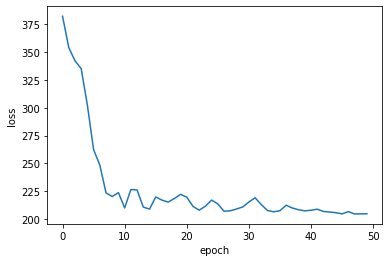

In [50]:
# We can make a plot to observe better
import matplotlib.pyplot as plt

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Although slow, we can observe that the model works and seems to improve over time.

### Cleaning

In [ ]:
# We will clean some variables that will not be used again
train_sample = None
train_sample_y = None
train_sample_len = None
train_sample_X = None
input_seq = None
X_np = None
Y_np = None

## 3.3 Build and Train the PyTorch Model

Once the training script works correctly, we will copy adecuately on the train.py file.

A typical training script:

- Loads training data from a specified directory
- Parses any training & model hyperparameters (ex. nodes in a neural network, training epochs, etc.)
- Instantiates a model of your design, with any specified hyperparams
- Trains that model
- Finally, saves the model so that it can be hosted/deployed, later


In [44]:
# !pygmentize source/train.py

## 3.4 Create Pytorch Estimator

In [47]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# specify an output path
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point = 'train.py',
                    source_dir = 'source',
                    role = role,
                    framework_version = '1.0',
                    train_instance_count = 1,
                    train_instance_type = 'ml.c4.xlarge',
                    output_path = output_path,
                    sagemaker_session = sagemaker_session,
                    hyperparameters = {
                        'input_dim': 27,
                        'output_dim': 27,
                        'hidden_dim': 128,
                        'epochs': 10,
                        'lr': 0.01,
                    })

## 3.5 Train the Estimator

This will take some time, take it easy.

In [48]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-03 08:09:29 Starting - Starting the training job...
2020-08-03 08:09:31 Starting - Launching requested ML instances......
2020-08-03 08:10:35 Starting - Preparing the instances for training...
2020-08-03 08:11:29 Downloading - Downloading input data
2020-08-03 08:11:29 Training - Downloading the training image...
2020-08-03 08:11:43 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-03 08:11:44,614 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-03 08:11:44,616 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-03 08:11:44,628 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-03 08:11:44,629 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-03 08:11:44,914 sagemaker-containers INFO     

Epoch: 1, NLLLoss: 316.218454771404
Epoch: 2, NLLLoss: 231.0692465818381
Epoch: 3, NLLLoss: 228.16348937795132
Epoch: 4, NLLLoss: 221.26883584034593
Epoch: 5, NLLLoss: 221.95427208912523
Epoch: 6, NLLLoss: 224.22091628931744
Epoch: 7, NLLLoss: 221.80863054492806
Epoch: 8, NLLLoss: 221.3189378327961
Epoch: 9, NLLLoss: 226.72853885119474
Epoch: 10, NLLLoss: 233.3437530179567
2020-08-03 08:17:34,533 sagemaker-containers INFO     Reporting training SUCCESS

2020-08-03 08:17:44 Uploading - Uploading generated training model
2020-08-03 08:17:44 Completed - Training job completed
Training seconds: 396
Billable seconds: 396
CPU times: user 1.19 s, sys: 34.4 ms, total: 1.23 s
Wall time: 8min 45s


# 4 Prediction with the trained Model

## 4.1 Getting letters back

We need a function that allows to obtain the words back from the padded version to the shorter integer version, and from this integer version to the string version using the dictionaries. This will be done in the following functions.

If the model returns all 0's (in the case it had a bad performance). The word will consist of a '.'.

Also this will be useful if we want to show how the words in the sentence have been jumbled.

In [49]:
def convert_back_and_unpad(number_dict, word, len_word):
    
    word_back = []
    for letter_index, letter in enumerate(word):
        if letter_index < len_word:
            if letter in number_dict:
                word_back.append(number_dict[letter])
            else:
                word_back.append('.')
                        
    return word_back


def convert_back_data(number_dict, data, len_data):
    result = []
    
    perc=0
    idx_w = 0
    for word, len_w in zip(data, len_data):
        if idx_w / len(data) >= perc:
            print('{} / {} words = {}%'.format(idx_w, len(data), np.round(perc*100, decimals = 1)))
            perc = perc+0.1


#         print('word------>', word)
        converted_word = convert_back_and_unpad(number_dict, word, len_w)
#         print('word converted--->', converted_word, leng_word)

        result.append(converted_word)
        idx_w += 1
        
#     return np.array(result), np.array(lengths)
    return result

In [50]:
# We will use the input training data to check and we will see how the sentence would be seen once jumbled
def join_sentence(sentence):
    list_words = []
    for word in sentence:
        w = ''.join(word)
        list_words.append(w)

    sentence_joined = ' '.join(list_words)
    
    return sentence_joined

In [51]:
# We will use the test dataset preparated, and assume that the sentence is the first 10 words of the file.
test_sample = pd.read_csv(os.path.join(model_dir, 'train.csv'), header=None, names=None, nrows=10)
test_sample_x = test_sample[test_sample.columns[35:69]].to_numpy(copy=True)
test_sample_len = test_sample[test_sample.columns[34]].to_numpy(copy=True)
test_sample_y = test_sample[test_sample.columns[0:34]].to_numpy(copy=True)

# Check one sentence, we will consider 5 consecutive words from the training data as a sentence
input_words = convert_back_data(int2letter, test_sample_x, test_sample_len)
output_words = convert_back_data(int2letter, test_sample_y, test_sample_len)

print('{} \n<--> \n{}'.format(join_sentence(input_words), join_sentence(output_words)))

0 / 10 words = 0%
1 / 10 words = 10.0%
2 / 10 words = 20.0%
4 / 10 words = 30.0%
5 / 10 words = 40.0%
6 / 10 words = 50.0%
7 / 10 words = 60.0%
8 / 10 words = 70.0%
9 / 10 words = 80.0%
0 / 10 words = 0%
1 / 10 words = 10.0%
2 / 10 words = 20.0%
4 / 10 words = 30.0%
5 / 10 words = 40.0%
6 / 10 words = 50.0%
7 / 10 words = 60.0%
8 / 10 words = 70.0%
9 / 10 words = 80.0%
jsut more camrea usept senak sort need ohter bzeleadzd winllig 
<--> 
just more camera upset sneak sort need other bedazzled willing


## 4.2 Predict Function

We will do the same as we did with the training script to check it works first. The input will be the word already transformed into integer.

### Predicting a sentence

In order to predict the sentence as string, we will transform the sentence into its integer jumbled form.

In [52]:
def prepare_predict(sentence, dictionary):
    input_data_words = post_to_words(sentence)
    
    print('Converting data')
    integer_sentence, len_sentence = convert_and_pad_data(dictionary, input_data_words)
    print('Jumbling data')
    jumbled_sentence = jumble_data(integer_sentence, len_sentence)
        
    return integer_sentence, jumbled_sentence, len_sentence

### Function

The words that are less than 4 letters, will be returned as such without passing through the model, as no transformation is really applied.

The function will check if the input is a string array or an integer array, and in the case of the string, it will apply the functions necesary to have the aduecuated type.

In [53]:
def predict(data_input, data_len, dictionary, model, device):
    
    if isinstance(data_input[0], str):
        print('Is an string sentence input')
        original_s_int, jumbled_s_int, data_len = prepare_predict(s, dictionary)
    else:
        print('Is an integer sentence input')
        jumbled_s_int = data_input.copy()
        
    integer_sentence = [] 
    for word in jumbled_s_int:
#         print('word: ', word)
        word_batch = [word]

        if len(word) > 3:
            dict_size = 27 #including the 0
            seq_len = 34
            batch_size =1
            test_seq = one_hot_encode(word_batch, dict_size, seq_len, batch_size)
            

            data = torch.from_numpy(test_seq).float().squeeze().to(device)
            # Have the torch as a batch of size 1
            data_batch = data.view(1, np.shape(data)[0], np.shape(data)[1])
#             print('size: {} -> {}'.format(np.shape(data), np.shape(data_batch)))
            # Make sure to put the model into evaluation mode
            model.eval()

            with torch.no_grad():
                
                output = model.forward(data_batch)
                
                word_integer = []
                for letter in output[0]: #as there's only 1 batch
                    
#                     print('letter', np.shape(letter))
                    letter_numpy = letter.numpy()
#                     print('numpy', type(letter_numpy), np.shape(letter_numpy))
                    
                    max_value_ind = np.argmax(letter_numpy, axis=0)
#                     print(max_value_ind)
#                     print(letter_numpy)



                    word_integer.append(max_value_ind)
                
        else:

            word_integer = word_batch.copy()
            
        integer_sentence.append(word_integer)
#         print('integer word: ', word_integer) 
    print('Convert back sentences')
    string_sentence = join_sentence(convert_back_data(int2letter, integer_sentence, data_len))
    
    return integer_sentence, string_sentence

In [54]:
int_result, str_result = predict(test_sample_x, test_sample_len, letter2int, model, device)

print('(1st word) Result  -> Ground Truth:')
print(int_result[0])
print('->')
print(test_sample_y[0])
print('\nResulting sentence: {}'.format(str_result))

NameError: name 'model' is not defined

It works correctly (ignoring the model performance).

And now we will try with a sentence string.

In [55]:
s = 'A study from Cambridge, has stated that etcetera'

output_array, output_string = predict(s, None, letter2int, model, device)

print('\nResulting array:', output_array)
print('\nResulting string:', output_string)
print('\nLength original sentence was {}, length of returned sentence is {}'.format(len(s.split(' ')), 
                                                                                    len(output_string.split(' '))))

NameError: name 'model' is not defined

We can observe that it works fine, the rest depends on the model.

## 4.3 Predict Model

PyTorch models do not automatically come with .predict() functions attached so we have to create a predict.py file. This file is responsible for loading a trained model and applying it to passed in, numpy data. When you created a PyTorch estimator, you specified where the training script, train.py was located.

Also there's a utils.py file, which contains the functions necesary to make all the other work correctly.

Before we can deploy this custom PyTorch model, we have to take one more step: creating a PyTorchModel. This model is responsible for knowing how to execute a specific predict.py script and it is what we'll deploy to create an endpoint.

Also don't forget to copy the predict function into the predict.py file.

In [60]:
%%time
# importing PyTorchModel
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data
# And point to the prediction script
model = PyTorchModel(model_data = estimator.model_data,
                     role = role,
                     framework_version = '1.0',
                     source_dir = 'source',
                     entry_point = 'predict.py',
                    )

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


CPU times: user 11.9 ms, sys: 3.72 ms, total: 15.6 ms
Wall time: 45 ms


### 4.3.1 Deploy trained Model

In [61]:
%%time
# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------------------------*

UnexpectedStatusException: Error hosting endpoint sagemaker-pytorch-2020-08-03-09-04-40-684: Failed. Reason:  The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint..

# 5 Evaluate the Model

Once the model is deployed, we can see how it performs when applied to the test data.

The provided function below, takes in a deployed predictor and the sentence and returns teo metrics: the accuracy of words which has been completely correctly reconstructed in the sentence, and the accuracy of letters that have been positioned correctly in the sentence.

Also if you want to try it with the predict function written in the section 4.2, you only have to replace the predictor.predict for a predict.

In [68]:
#Helping function
def equalArrays(arr1, arr2):
    equal = True
    for i1, i2 in zip(arr1, arr2):
        if i1!=i2:
            equal = False
    return equal

# code to evaluate the endpoint on test data
# returns a variety of model metrics
# def sentence_accuracy(predictor, sentence, verbose=True):
def evaluate(sentence, ground_truth, lengths, dictionary, model, device, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # Obtain the result of the prediction
#     predict_array, predict_string = predict(sentence, lengths, dictionary, model, device)
    predict_array, predict_string = predictor.predict(sentence, model, device)
       
    # Both sentences have to have the same number of words
    if len(sentence) != len(ground_truth):
        print('error in the length obtained')
        return 0
    
    correct_w = 0
    correct_l = 0
    
    for original, result, length in zip(ground_truth, predict_array, lengths):
        if equalArrays(original, result):
            print('Correct prediction: Original {} -> Result {}'.format(join_sentence(convert_back_and_unpad(int2letter, original, length)), string))
            correct_w += 1
        for lo, lr in zip(original, result):
            if lo == lr:
                correct_l += 1
                
    accuracy_w = correct_w / len(sentence)
    accuracy_l = correct_l
    
    return accuracy_w, accuracy_l

We have to read the test.csv file to obtain all the test words.

In [69]:
evaluate_sample = pd.read_csv(os.path.join(model_dir, 'test.csv'), header=None, names=None)
eval_sample_x = evaluate_sample[evaluate_sample.columns[35:69]].to_numpy(copy=True)
eval_sample_len = evaluate_sample[evaluate_sample.columns[34]].to_numpy(copy=True)
eval_sample_y = evaluate_sample[evaluate_sample.columns[0:34]].to_numpy(copy=True)
acc_w, acc_l = evaluate(eval_sample_x, eval_sample_y, eval_sample_len, letter2int, model, device)
print(eval_sample_len)
print(np.sum(eval_sample_len))
print('Word Accuracy: {}'.format(acc_w))
print('Letter Accuracy: {}'.format(acc_l))

Is an integer sentence input
Convert back sentences
0 / 22618 words = 0%
2262 / 22618 words = 10.0%
4524 / 22618 words = 20.0%
6786 / 22618 words = 30.0%
9048 / 22618 words = 40.0%
11309 / 22618 words = 50.0%
13571 / 22618 words = 60.0%
15833 / 22618 words = 70.0%
18095 / 22618 words = 80.0%
20357 / 22618 words = 90.0%
g [ 3 15 12 15 18  1  4 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]
p [3, 15, 13, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
l 8
Word Accuracy: 0.0
Letter Accuracy: 0.49345240922838185


# 6 Delet the endpoint & Final cleanup

In [ ]:
# Accepts a predictor endpoint as input
# And deletes the endpoint by name
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [ ]:
# delete the predictor endpoint 
delete_endpoint(predictor)

Check that we have cleaned deleted all our endpoints, S3 bucket, models, and endpoint configurations.

In [ ]:
import sys

print(sys.getsizeof(X_np))

In [ ]:
%whos